In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob

In [4]:
import lanelines
import roadplane

from compgraph import CompGraph, CompGraphRunner
import nxpd
nxpd.nxpdParams['show'] = 'ipynb'

In [5]:
from newlanespipeline import computational_graph as cg
from newlanespipeline import parameters as cg_params

## Initialization

In [6]:
cm = np.load('serialize/camera_matrix.npy')
dc = np.load('serialize/dist_coefs.npy')

In [7]:
CANVAS_SZ = (500, 1500)
OFFSET_X = 100
OFFSET_Y = 0

straight_images_files = ('test_images/straight_lines1.jpg', 'test_images/straight_lines2.jpg')
straight_images = [lanelines.open_image(f) for f in straight_images_files]
straight_images_undist = [cv2.undistort(im, cm, dc) for im in straight_images]

warp_src = roadplane.define_flat_plane_on_road(straight_images_undist, x_offset=0)
warp_src[1, 0] += 8 # <- a hack
warp_dst = lanelines.get_rectangle_corners_in_image(CANVAS_SZ, offset_x=OFFSET_X, offset_y=OFFSET_Y)

M = cv2.getPerspectiveTransform(warp_src, warp_dst)
Minv = cv2.getPerspectiveTransform(warp_dst, warp_src)

In [8]:
test_images = [lanelines.open_image(f) for f in glob('test_images/*.jpg')]
test_images_undist = [cv2.undistort(im, cm, dc) for im in test_images]

## Pipeline

In [9]:
my_params = cg_params.copy()
my_params['canvas_size'] = CANVAS_SZ
#my_params['n_cells_y'] = 50

runner = CompGraphRunner(cg, frozen_tokens=my_params)

#nxpd.draw(runner.token_manager.to_networkx())

## Experiments

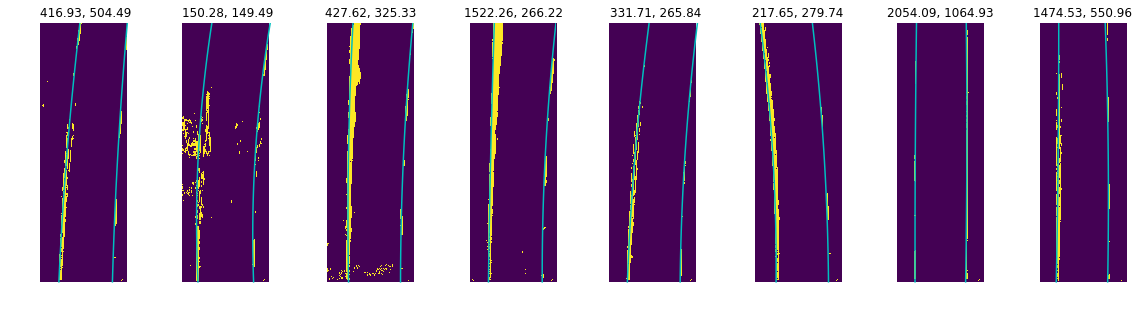

In [10]:
last_y = CANVAS_SZ[1]
PIXELS_PER_METER = 50

plt.figure(figsize=(20, 5))

for i, im in enumerate(test_images_undist):
    runner.run(image=im, M=M)
    
    plt.subplot(1, 8, i+1)
    plt.imshow( runner['all_thresholds'])
    _ = plt.axis('off')
    
    poly_y, poly_x_left, poly_x_right = lanelines.get_lane_polynomials_points( 
        runner['warped'],
        runner['p_coefs_left'], 
        runner['p_coefs_right']
    )
    
    plt.plot(poly_x_left, poly_y, color='c')
    plt.plot(poly_x_right, poly_y, color='c')
    
    curv_left = lanelines.curvature_poly2(runner['p_coefs_left'], last_y)
    curv_right = lanelines.curvature_poly2(runner['p_coefs_right'], last_y)
    
    plt.title('{:.2f}, {:.2f}'.format(curv_left / PIXELS_PER_METER, curv_right / PIXELS_PER_METER))


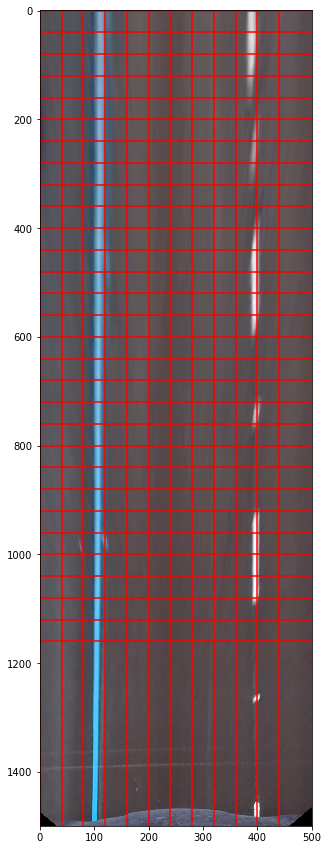

In [13]:
plt.figure(figsize=(10, 15))

plt.imshow(runner['warped'])
for i in range(30):
    plt.axhline(i * 40, color='r')
    
for i in range(12):
    plt.axvline(i * 40, color='r')

In [12]:
3.7 / 3

1.2333333333333334